In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Load the dataset
data = pd.read_csv("stress.csv")
print(data.head())

          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text     id  label  \
0  He said he had not felt that way before, sugge...  33181      1   
1  Hey there r/assistance, Not sure if this is th...   2606      0   
2  My mom then hit me with the newspaper and it s...  38816      1   
3  until i met my new boyfriend, he is amazing, h...    239      1   
4  October is Domestic Violence Awareness Month a...   1421      1   

   confidence  social_timestamp  social_karma  syntax_ari  ...  \
0         0.8        1521614353             5    1.806818  ...   
1         1.0        1527009817             4    9.429737  ...   
2         0.8        1535935605             2    7.769821  ...   
3         0.6        1516429555       

In [4]:
# Check for null values
print(data.isnull().sum())

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64


In [5]:
# Download NLTK stopwords
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Set of stopwords
stopword = set(stopwords.words('english'))

In [7]:
# Define the clean function
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

In [8]:
# Clean the text data
data["text"] = data["text"].apply(clean)

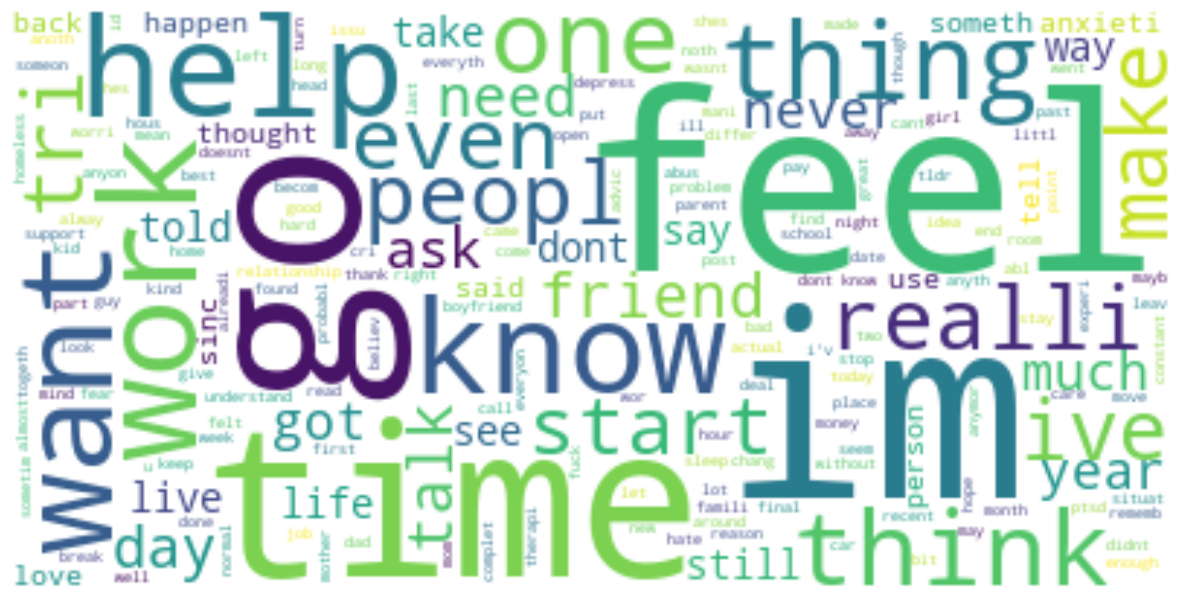

In [9]:
# Generate a word cloud
text = " ".join(i for i in data.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
# Map labels to "No Stress" and "Stress"
data["label"] = data["label"].map({0: "No Stress", 1: "Stress"})
data = data[["text", "label"]]
print(data.head())

                                                text      label
0  said felt way sugget go rest trigger ahead you...     Stress
1  hey rassist sure right place post goe  im curr...  No Stress
2  mom hit newspap shock would know dont like pla...     Stress
3  met new boyfriend amaz kind sweet good student...     Stress
4  octob domest violenc awar month domest violenc...     Stress


In [11]:
# Feature extraction and train-test split
x = np.array(data["text"])
y = np.array(data["label"])


In [12]:
# Feature extraction with TF-IDF and n-grams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X = tfidf.fit_transform(data["text"])
y = data["label"]

In [13]:
# Train-test split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
# Ensemble model: Voting Classifier
bnb = BernoulliNB()
lr = LogisticRegression(max_iter=200)
rf = RandomForestClassifier(n_estimators=200)
svm = SVC(probability=True)

voting_clf = VotingClassifier(estimators=[
    ('bnb', bnb),
    ('lr', lr),
    ('rf', rf),
    ('svm', svm)
], voting='soft')


In [15]:
# Train and evaluate the ensemble model
voting_clf.fit(xtrain, ytrain)
accuracy = voting_clf.score(xtest, ytest)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")

Ensemble Model Accuracy: 77.27%


In [16]:
# Function to predict stress or no stress
def predict_stress(sentence):
    cleaned_sentence = clean(sentence)
    transformed_sentence = tfidf.transform([cleaned_sentence])
    prediction = voting_clf.predict(transformed_sentence)
    return prediction[0]

In [17]:

# Example usage
user_input = "I have so much work to do and I don't know where to start!"
prediction = predict_stress(user_input)
print(f"The input sentence is predicted to be: {prediction}")





The input sentence is predicted to be: Stress


In [18]:
# Example usage with random user input
user_input = input("Enter a Text: ")
prediction = predict_stress(user_input)
print(f"The input sentence is predicted to be: {prediction}")

The input sentence is predicted to be: No Stress


In [19]:
import joblib

# Save model and vectorizer
joblib.dump(voting_clf, "stress_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("✅ Model and vectorizer saved!")


✅ Model and vectorizer saved!
